# Data Processing

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import missingno as msno
import os
import math
%matplotlib inline

In [2]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
kmeans = KMeans()

### Loading the Data

In [3]:
autos = pd.read_csv('autos.csv')
autos_misc = pd.read_csv('cnt_km_year_powerPS_minPrice_maxPrice_avgPrice_sdPrice.csv')

In [4]:
autos.head(1)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57


In [5]:
print "Autos CSV Dimensions", autos.shape
a_rows = autos.shape[0]

Autos CSV Dimensions (371528, 20)


In [6]:
autos_misc.head(1) #SQL processed from the autos.csv, obtained from Kaggle

,count,km,year,powerPS,minPrice,maxPrice,avgPrice,sdPrice
0,19,125000,1991,40,300,1499,648.3158,352.035293


In [7]:
print "Misc Dimensions", autos_misc.shape

Misc Dimensions (1770, 8)


In [8]:
autos.dtypes.value_counts()

object    13
int64      7
dtype: int64

In [9]:
autos_num = autos.select_dtypes(include=[np.number]) #Subset for numerical values

# autos_num['name'] = autos.name
# cols = autos_num.columns.tolist()
# cols = cols[-1:] + cols[:-1]
# autos_num = autos_num[cols]

autos_num.head(1)

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
0,480,1993,0,150000,0,0,70435


<br>

### Pre-Processing

#### Estimating Memory Size for Data Frame:

In [10]:
def df_size(df):
    """Return the size of a DataFrame in Megabytes"""
    total = 0.0
    for col in df:
        total += df[col].nbytes
    return total/1048576

print "Size(MB):", df_size(autos)

Size(MB): 56.6906738281


** Changing data objects into appropriate data types **

In [11]:
from datetime import datetime


In [12]:
autos.dateCreated = pd.to_datetime(autos.dateCreated)

# autos.name.dtypes #'O' denotes Object
# str_col = autos.select_dtypes(include=['O']).columns
# autos[str_col] = autos[str_col].astype('str')

<br>

<br>
#### Cleaning

In [13]:
# For bogus posts with repdigits
repdigit = [] 
for i in range(1L,10L):
    repdigit.append(111*i)
    repdigit.append(1111*i)
    repdigit.append(11111*i)
    repdigit.append(111111*i)

#Getting rid of unwanted ranges and terms
autos = autos[(autos.price > 500)
             & (autos.price < 600000)
             & (autos.yearOfRegistration > 1930)
             & (autos.kilometer > 0)
             & (autos.kilometer < 241401)
             & (autos.powerPS > 0)
             & (autos.powerPS < 1000)
             & (autos.brand != 'sonstige_autos')
             & (autos.price.isin(repdigit) == False)
             & (autos.offerType == 'Angebot')
             & (autos.seller != 'gewerblich')
             & (autos.name.str.contains('Suche','Haben') == False)]

#Dropping abtest since creator of the CSV states they cannot find meaning in the column
autos = autos.drop("abtest", 1)
autos = autos.drop("dateCrawled", 1)
autos = autos.drop("lastSeen", 1)
autos = autos.drop("nrOfPictures", 1) #Column contains all zeroes! Useless (especially for log transformation)
autos = autos.drop_duplicates()

print "Dimensions after cleaning:", autos.shape
print "Number of rows filtered out:", a_rows - autos.shape[0]

Dimensions after cleaning: (290916, 16)
Number of rows filtered out: 80612


In [21]:
autos_num = autos.select_dtypes(include=[np.number]) #Update after filtering
autos.head(1)

,name,seller,offerType,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode
1,A5_Sportback_2.7_Tdi,privat,Angebot,18300,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24,66954


#### NA Values

In [14]:
na_check = autos.dropna()
print "Dimensions without NA values:", na_check.shape
print "Number of NA values:", autos.shape[0] - na_check.shape[0]

Dimensions without NA values: (230837, 16)
Number of NA values: 60079


In [15]:
na_list = autos.shape[0] - autos.count()
na_list[na_list > 0] #Seems like the non-numeric rows are the only ones with missing data

vehicleType          17388
gearbox               4892
model                 8707
fuelType             15825
notRepairedDamage    38886
dtype: int64

In [16]:
# autos = autos.dropna()

<br>

#### Summary

In [17]:
autos_num.corr()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
price,1.000000,-0.000182,0.006850,-0.000635,-0.002826,NaN,-0.003164
yearOfRegistration,-0.000182,1.000000,0.000351,-0.055319,-0.011607,NaN,-0.001652
powerPS,0.006850,0.000351,1.000000,-0.010738,0.044358,NaN,0.027113
kilometer,-0.000635,-0.055319,-0.010738,1.000000,0.001838,NaN,-0.026694
monthOfRegistration,-0.002826,-0.011607,0.044358,0.001838,1.000000,NaN,0.014963
nrOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postalCode,-0.003164,-0.001652,0.027113,-0.026694,0.014963,NaN,1.000000


In [22]:
np.log(autos_num).corr()

# auto_log = autos
# auto_log.price = np.log(autos.price)
# auto_log.corr().loc[:,'price'].abs().sort_values(ascending=False)[1:]

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,postalCode
price,1.000000,0.194922,0.558237,-0.378330,0.006457,0.064272
yearOfRegistration,0.194922,1.000000,0.072332,-0.144024,-0.004605,0.012704
powerPS,0.558237,0.072332,1.000000,0.013572,0.011981,0.052394
kilometer,-0.378330,-0.144024,0.013572,1.000000,0.008951,-0.017084
monthOfRegistration,0.006457,-0.004605,0.011981,0.008951,1.000000,-0.002902
postalCode,0.064272,0.012704,0.052394,-0.017084,-0.002902,1.000000


In [23]:
autos.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,postalCode
count,290916.000000,290916.000000,290916.000000,290916.000000,290916.000000,290916.000000
mean,6651.138648,2004.262495,129.074949,124716.602043,6.062045,51798.007277
std,9357.902458,30.335197,61.922739,39525.354072,3.551644,25682.188012
min,501.000000,1931.000000,1.000000,5000.000000,0.000000,1067.000000
25%,1750.000000,2000.000000,86.000000,100000.000000,3.000000,31515.000000
50%,3850.000000,2004.000000,116.000000,150000.000000,6.000000,50996.000000
75%,8400.000000,2009.000000,155.000000,150000.000000,9.000000,72555.000000
max,599000.000000,9999.000000,999.000000,150000.000000,12.000000,99998.000000


#### Distribution of Price

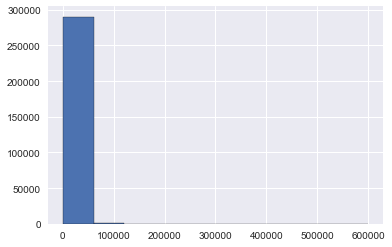

In [24]:
plt.hist(autos.price,edgecolor='black'); #Outliers have a strong effect, trying log transform to reduce outlier impact

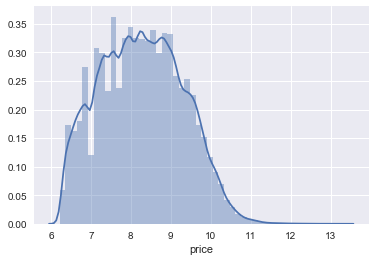

In [25]:
sns.distplot(np.log(autos.price)) #Much more interpretable, distribution seems to be normal with some extreme right outliers

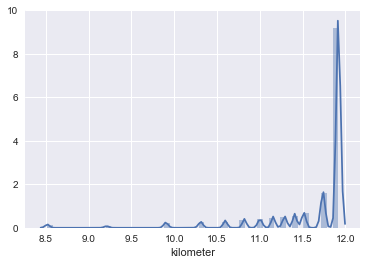

In [44]:
sns.distplot(np.log(autos.kilometer)) #Still doesn't do well 

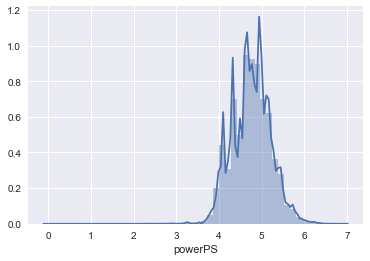

In [45]:
sns.distplot(np.log(autos.powerPS))

** scatter plot (price vs km) ** 

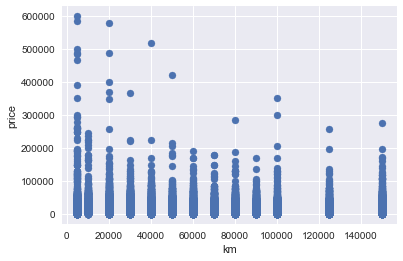

In [36]:
plt.scatter(autos.kilometer,autos.price)
plt.ylabel('price')
plt.xlabel('km')

#### groupby graphs

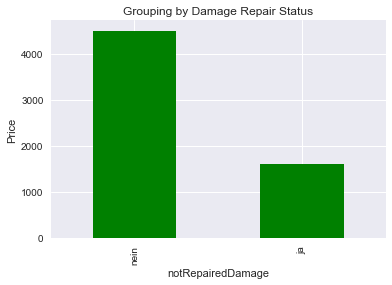

In [26]:
a_head = autos.price.groupby(by=(autos.notRepairedDamage), sort=True).median().sort_values(ascending=False).head(20).plot.bar(color='g')
plt.ylabel('Price')
plt.title('Grouping by Damage Repair Status')

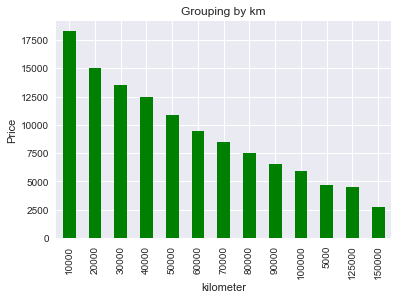

In [27]:
a_head = autos.price.groupby(by=(autos.kilometer), sort=True).median().sort_values(ascending=False).head(20).plot.bar(color='g')
plt.ylabel('Price')
plt.title('Grouping by km')

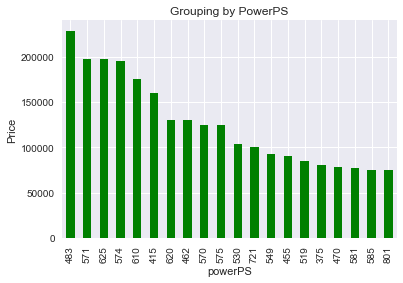

In [28]:
a_head = autos.price.groupby(by=(autos.powerPS), sort=True).median().sort_values(ascending=False).head(20).plot.bar(color='g')
plt.ylabel('Price')
plt.title('Grouping by PowerPS')

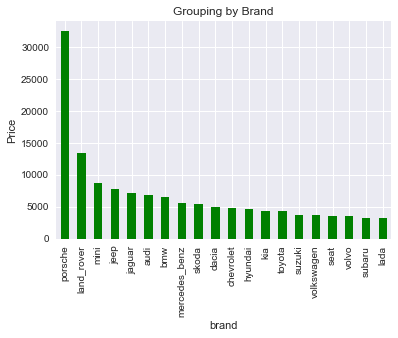

In [29]:
a_head = autos.price.groupby(by=(autos.brand), sort=True).median().sort_values(ascending=False).head(20).plot.bar(color='g')
plt.ylabel('Price')
plt.title('Grouping by Brand')

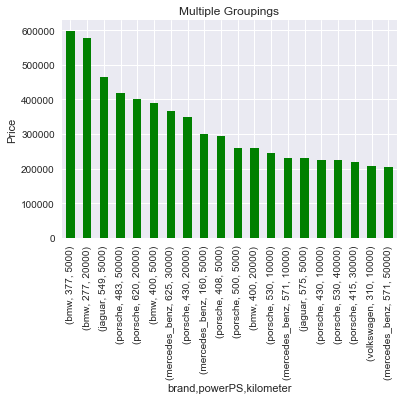

In [30]:
#Brand and Horsepower
a_head = autos.price.groupby(by=(autos.brand,autos.powerPS,autos.kilometer), sort=True).median().sort_values(ascending=False).head(20).plot.bar(color='g')
plt.ylabel('Price')
plt.title('Multiple Groupings')


In [31]:
pd.DataFrame(autos.price.groupby(by=(autos.brand,autos.powerPS,autos.kilometer), sort=True).median()).head(20)

price
brand      powerPS kilometer         
alfa_romeo 50      40000       1950.0
           63      125000      4500.0
           65      80000      10900.0
           68      40000       6750.0
                   80000       1100.0
           77      30000      10600.0
                   125000      3500.0
                   150000      1175.0
           78      30000       6999.0
                   150000      4300.0
           79      70000       7350.0
                   80000       5900.0
                   90000       2850.0
                   150000      4800.0
           82      100000     13500.0
           83      80000       8000.0
           84      60000      16750.0
           85      100000     29950.0
                   125000     12500.0
           86      125000      4300.0

In [32]:
autos.to_csv('autos_processed.csv')

<br>

<br>